# HW3: Hamiltonian Monte Carlo


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Eric Weiner

**Names of any collaborators:** _Names here_

*Due: 11:59pm Friday, April 23, 2021 via GradeScope*

---

In this homework assignment you'll perform MCMC with both Metropolis-Hastings Hamiltonian Monte Carlo. We will investigate the Federalist papers---specifically, modeling the rate at which Hamilton (we're using HMC after all!) uses the word _can_ in his papers. 

We will fit this model using a negative binomial distribution. That is, for each document $n$ that Hamilton wrote, we have the number of times the word 'can' appears $y_n$ as 
\begin{align}
y_n \sim \text{NB}(\mu_n, r)
\end{align}
where 
\begin{align}
\text{NB}(y_n \mid \mu_n, r) = \frac{\Gamma(y_n+r)}{\Gamma(r) \Gamma(y_n+1)} \left(\frac{r}{\mu_n + r}\right)^r \left(1 - \frac{r}{\mu_n + r}\right)^{y_n}
\end{align}
The mean is given by $\mathbb{E}[y_n] = \mu_n$, and $r$ controls the dispersion. Here, we model the mean for document $n$ as
\begin{align}
\mu_n = \frac{T_n}{1000} \mu
\end{align}
where $\mu$ is the rate of usage of 'can' per 1000 words and $T_n$ is the number of words in document $n$ (i.e. the document length).

For our model, we will use the following prior for the non-negative parameters,
\begin{align}
\log \mu &\sim \mathcal{N}(0, 9) \\
\log r &\sim \mathcal{N}(0, 9)
\end{align}

In a classic paper, Mosteller and Wallace (JASA, 1963) used likelihood ratios under negative binomial models with different mean rates for Alexander Hamilton and James Madison to infer the more likely author of disputed Federalist papers. Spoiler alert: while Hamilton wrote the majority of the papers, the 12 disputed papers appear to be Madison's! A key step in their analysis was estimating the NB parameters. While Mosteller and Wallace used a point estimate for each word and author, you'll do full posterior inference, focusing on Hamilton's use of the word _can_.


In [1]:
import wget
wget.download('https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw3/federalist_can_hamilton.csv')


'federalist_can_hamilton.csv'

In [1375]:
import pandas as pd
import autograd.numpy as np 
from autograd import grad

# Load the data
df = pd.read_csv('federalist_can_hamilton.csv')
Ts = np.array(df['Total'])
ys = np.array(df['N'])

## Problem 1  [math]: Show that the negative binomial can be expressed as the marginal distribution of a Poisson with gamma prior

Similar to how the Student's t distribution is a marginal of an inverse chi-squared and a Gaussian, show that

\begin{align}
\text{NB}(y \mid \mu, r) = \int \text{Po}(y \mid \lambda) \, \text{Ga}(\lambda \mid \alpha,\beta) \, \mathrm{d}\lambda
\end{align}

Express the parameters of the negative binomial distribution as a function of the parameters of the gamma distribution. (Assume $\beta$ is the rate parameter.)

We start off by defining the following:

\begin{align}
\text{NB}(y \mid \mu, r) = \int \frac{\lambda^{y_{n}}e^{-\lambda}}{y_{n}!} \frac{\beta^\alpha}{\Gamma(\alpha)}\lambda^{\alpha -1}e^{-\beta \lambda} \mathrm{d}\lambda
\end{align}

We can take some terms out that do not depend on $\lambda$:

\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\beta^\alpha}{\Gamma(\alpha)y_n!} \int \lambda^{y_{n}}e^{-\lambda} \lambda^{\alpha -1}e^{-\beta \lambda} \mathrm{d}\lambda
\end{align}

Rearranging the terms inside the integral gets us the following:
\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\beta^\alpha}{\Gamma(\alpha)y_n!} \int \lambda^{(y_n + \alpha -1)}e^{-\lambda(\beta+1)} \mathrm{d}\lambda
\end{align}

We can now rewrite the integral as follows:

\begin{align}
\int \lambda^{(y_n + \alpha -1)}e^{-\lambda(\beta+1)} \mathrm{d}\lambda = \frac{\Gamma(y_n +\alpha)}{(\beta+1)^{(y_n+\alpha)}}
\end{align}

Thus, we can rewrite the Negative Binomial distribution as:

\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\beta^\alpha}{\Gamma(\alpha)y_n!} \frac{\Gamma(y_n +\alpha)}{(\beta+1)^{(y_n+\alpha)}}
\end{align}

To simplify more, we see that we can rewrite $y_n! = \Gamma(y_n+1)$ and after some rearranging we get:


\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\Gamma(y_n +\alpha)}{\Gamma(\alpha)\Gamma(y_n+1)} \frac{\beta^\alpha}{(\beta+1)^{(y_n+\alpha)}}
\end{align}

If we set $r= \alpha$, we get the following:

\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \frac{\beta^r}{(\beta+1)^{(y_n+r)}}
\end{align}

After some more rearranging...

\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \left( \frac{\beta}{\beta+1} \right)^r \left( \frac{1}{\beta+1} \right)^{y_n}
\end{align}

If we set $\beta = \frac{r}{\mu_n}$

\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \left( \frac{\frac{r}{\mu_n}}{\frac{r}{\mu_n}+1} \right)^r \left( \frac{1}{\frac{r}{\mu_n}+1} \right)^{y_n}
\end{align}

\begin{align}
\text{NB}(y \mid \mu, r) =\frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \left( \frac{r}{\mu_n + r} \right)^r \left( \frac{1}{\frac{r}{\mu_n}+1} \right)^{y_n}
\end{align}

We can rearrage the far right term after noticing that $\frac{1}{\beta + 1} =1- \frac{\beta}{\beta +1}$. We then get the Negative Binomial Distribution in the problem statement:

\begin{align}
\text{NB}(y_n \mid \mu, r) =\frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \left( \frac{r}{\mu_n + r} \right)^r \left(1 - \frac{r}{\mu_n + r}\right)^{y_n}
\end{align}

## Problem 2: Implement the log joint probability of the model

Start off by defining the log joint probability as follows:
\begin{align}
\log p(y_n,\mu,r) = \log \left( p(y_n | \mu_n,r) \times p(\mu_n,r) \right)
\end{align}

After distributing the log
\begin{align}
\log p(y_n,\mu,r) = \log \left( p(y_n | \mu_n,r) \right) +  \log p(\mu) + \log p(r)
\end{align}


\begin{align}
\log p(y_n,\mu,r) = \log \left(\prod p(y_n | \mu_n,r) \right) +  \log p(\mu) + \log p(r)
\end{align}

\begin{align}
\log p(y_n,\mu,r) = \sum \left( \log p(y_n | \mu_n,r) \right) +  \log p(\mu) + \log p(r)
\end{align}

\begin{align}
\log p(y_n,\mu,r) = \sum \left( \log( \sim \text{NB}(y_n|\mu,r) \right)) +  \log(e^{\sim N(0,9)}) + \log (e^{\sim N(0,9)})
\end{align}


\begin{align}
\log (\text{NB}(y_n \mid \mu, r)) =\log \left( \frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \left( \frac{r}{\mu_n + r} \right)^r \left(1 - \frac{r}{\mu_n + r}\right)^{y_n} \right) = \log \left(\frac{\Gamma(y_n +r)}{\Gamma(r)\Gamma(y_n+1)} \right) + \log \left( \frac{r}{\mu_n + r} \right)^r + \log \left(1 - \frac{r}{\mu_n+r} \right)^{y_n}
\end{align}


\begin{align}
\log (\text{NB}(y_n \mid \mu, r))  = \log \left(\Gamma(y_n +r) \right) - \log \Gamma(r) -\log \Gamma(y_n+1) +r \log \left(\frac{r}{\mu_n + r} \right) + y_n \log \left(1 - \frac{r}{\mu_n+r} \right)
\end{align}


In [1395]:
#import scipy as sc
from scipy.stats import nbinom
from scipy.stats import norm
from autograd.scipy.special import gammaln
import autograd.numpy as np 
from autograd import grad

lpn_mu = np.random.normal(0,3)
lpn_r = np.random.normal(0,3)

def ljp(y,T,N,log_mu, log_r):    
    r = np.exp(log_r)
    mu = np.exp(log_mu)
    mu_n = (T/1000)*mu
   
    ###the steps below are to calculate the log likelihood of the NB distribution
    lpnb_y = np.zeros(N)
    #i=0
    for i in range(N):
        first_a = gammaln(y[i]+r)
        first_b = gammaln(r) 
        first_c =  gammaln(y[i]+1)
        second = r*np.log(r/(mu_n[i]+r))
       
        third = y[i]*np.log(1 - (r/(mu_n[i] + r)))
      
        lpnb_y[i] = first_a - first_b - first_c + second + third
        
    
    return  np.log(norm.pdf(lpn_mu,0,3)) + np.log(norm.pdf(lpn_r,0,3)) + np.sum(lpnb_y) 

print(ljp(ys.astype(np.float64), Ts, len(ys), lpn_mu, lpn_r))




-255.18320985433212


For the following MC implementation problems, sample in $\log(\mu), \log(r)$ space. Initialize with $\log(\mu) = 0, \log(r) = 0$.

## Problem 3: Implement Metropolis-Hastings

Implement and run Metropolis-Hastings with a spherical Gaussian proposal. Try various proposal variances.

In [1551]:
##want posterior distribution of parameters mu and r
from scipy.stats import multivariate_normal

def mh(y,T,log_mu_0, log_r_0, covariance):
    loop = 500
##Step1: define the transition model
##told it to be a spherical gaussian, will need a mean vector and covariance matrix
#mean vector should be current log(mu) and log(r)
    mu_curr = log_mu_0
    r_curr = log_r_0
    mean_curr = [mu_curr, r_curr]
    theta_propose = np.zeros((loop,2))
    acceptances = np.zeros(loop)
    i=0
    theta_accepted = []
    for i in range(loop):
        theta_prop_curr = np.random.multivariate_normal(mean_curr, covariance)
        log_mu_prop = theta_prop_curr[0]
        log_r_prop = theta_prop_curr[1]
        theta_curr_prop = np.random.multivariate_normal(theta_prop_curr, covariance)
   
        #q_prop_curr = multivariate_normal.pdf(theta_prop_curr, mean = mean_curr, cov = covariance)
        #q_curr_prop = multivariate_normal.pdf(theta_curr_prop, mean = theta_prop_curr, cov = covariance)
        
        
                       
        ljp_current = ljp(y,T, len(y), mean_curr[0], mean_curr[1])
        ljp_proposed = ljp(y,T, len(y), log_mu_prop, log_r_prop)
       
      
        acceptance =  ljp_proposed-ljp_current
        threshold = np.log(np.random.uniform(0,1))
        
        if (acceptance > threshold):
            mean_curr = theta_prop_curr
            #print("The current theta in the IF loop is{}".format(mean_curr))
            theta_propose[i,0] = theta_prop_curr[0]
            theta_propose[i,1] = theta_prop_curr[1]
            acceptances[i] = 1
            theta_accepted.append(theta_prop_curr)
            
        else:
            mean_curr = mean_curr
          
            theta_propose[i,0] = theta_prop_curr[0]
            theta_propose[i,1] = theta_prop_curr[1]
            acceptances[i] = 0
            theta_accepted.append(mean_curr)
            
          
  
    return  theta_accepted   


log_mu_mh = np.array(mh(ys, Ts, 0,0,(1/100)*np.identity(2)))[:,0]
log_r_mh = np.array(mh(ys, Ts, 0,0,(1/100)*np.identity(2)))[:,1]

## Problem 4: Implement Hamiltonian Monte Carlo

Implement the leapfrog step as a function, and run HMC. Try various step sizes and number of leapfrog steps.

In [1501]:
from autograd.scipy.special import digamma

def dUdr(mu, r):
    #partial of negative potential wrt to r which returns the gradient of the LJP 
    #evaluated at a particular points mu and r
    sigma_sq = 9
    lh = np.zeros(len(ys))
    mu_n = (Ts/1000)*mu
    ## derivative of terms inside the NB distribution
    for i in range(len(ys)):
        
        first = -1*(digamma(ys[i] + r))
        second =  digamma(r)
        third = -1*(np.log(r) - np.log(mu_n[i]+r) + 1 - (r/(mu_n[i]+r)))
        fourth =  ys[i]/(mu_n[i]+r)
        lh[i] = first + second + third + fourth # vector of individual likelihoods
        
    return (np.sum(lh)+(r/sigma_sq))



In [1500]:
def dUdmu(mu,r):
    #partial of negative potential wrt to mu which returns the gradient of the LJP 
    #evaluated at a particular points mu and r
    sigma_sq = 9
    lh = np.zeros(len(ys))
    mu_n = (Ts/1000)*mu
    ## derivative of terms inside the NB distribution
    for i in range(len(ys)):
        first = r/(mu_n[i]+r)
        second = -1*(ys[i]*((1/mu_n[i]) - (1/(mu_n[i]+r))))
        lh[i] = first + second
    return np.sum(lh) + (r/sigma_sq)

In [1503]:
def fullgrad(q):
    mu = np.exp(q[0,0])
    r = np.exp(q[1,0])
    
    dUdq = np.zeros((2,1))
    dUdq[0,0] = dUdmu(mu,r) 
    dUdq[1,0] = dUdr(mu,r)
    
    return dUdq
  

In [1504]:
###leap_frog integration step
def leap(q, p, time, epsilon):
    
    q, p = np.copy(q), np.copy(p)

 
    for i in range(int(time/epsilon)): 
        p = p - epsilon/2*fullgrad(q) #half step
        q = q +  epsilon*p  # whole step
        p = p - epsilon*fullgrad(q)/2  # half step

    # momentum flip at end
    return q, -p


In [1568]:
from scipy.stats import multivariate_normal    
def hmc(p0,time, epsilon):
    loop = 1000
    m = 1
    theta_propose_hmc = np.zeros((loop,2))
    acceptances_hmc = np.zeros(loop)
    q = np.array([0,0]).reshape((2,1))
    q_array = []
    
    for i in range(loop):
        #print("We are on loop{}".format(i))
        p = np.random.multivariate_normal([0,0],m*np.identity(2)).reshape((2,1))
        #print("The old q is {}".format(q))
        q_prop, p_prop = leap(q, p, time, epsilon)
        #print("The new q is {}".format(q_prop))
        proposed_potential = -ljp(ys, Ts, len(ys), q_prop[0,0], q_prop[1,0])
        proposed_kinetic = np.sum(multivariate_normal.pdf(p_prop, mean =[0,0], cov=m*np.identity(2)))
        proposed = proposed_potential - proposed_kinetic
        
        #print("The proposed potential is{}".format(proposed_potential))
        #print("The proposed kinetic is{}".format(proposed_kinetic))
           
        current_potential = -ljp(ys, Ts, len(ys), q[0,0], q[1,0])
        current_kinetic = np.sum(multivariate_normal.pdf(p, mean =[0,0], cov=m*np.identity(2)))
        current = current_potential - current_kinetic
        #print("The current is{}".format(current))
        
        acceptance =  current - proposed
        threshold = np.log(np.random.uniform(0,1))
        #print("The acceptance is{}".format(acceptance))
        #print("The threshold is{}".format(threshold))
            
        if (acceptance > threshold):
            q = q_prop
            #print("The current theta in the IF loop is{}".format(mean_curr))
            theta_propose_hmc[i,0] = q_prop[0,0]
            theta_propose_hmc[i,1] = q_prop[1,0]
            acceptances_hmc[i] = 1
            q_array.append(q_prop)
            
        else:
            q = q
          
            theta_propose_hmc[i,0] = q[0,0]
            theta_propose_hmc[i,1] = q[1,0]
            acceptances_hmc[i] = 0
            q_array.append(q)
            
    return  q_array  

p0 = np.array([0.2,0.5]).reshape((2,1))
log_mu_hmc = np.array(hmc(p0,1,0.25))[:,0]
log_r_hmc = np.array(hmc(p0,1,0.25))[:,1] 

## Problem 5: Diagnostics

For both algorithms, make trace plots of the parameters and plot histograms of posterior marginals.

In [1589]:
###histogram data for metropolis hastings

loops = 200
hist_mh = np.zeros((loops,2))

for i in range(loops):
 #   print(i)
    hist_mh[i,0] = np.array(mh(ys, Ts, 0,0,(1/100)*np.identity(2)))[499,0]
    hist_mh[i,1] = np.array(mh(ys, Ts, 0,0,(1/100)*np.identity(2)))[499,1]

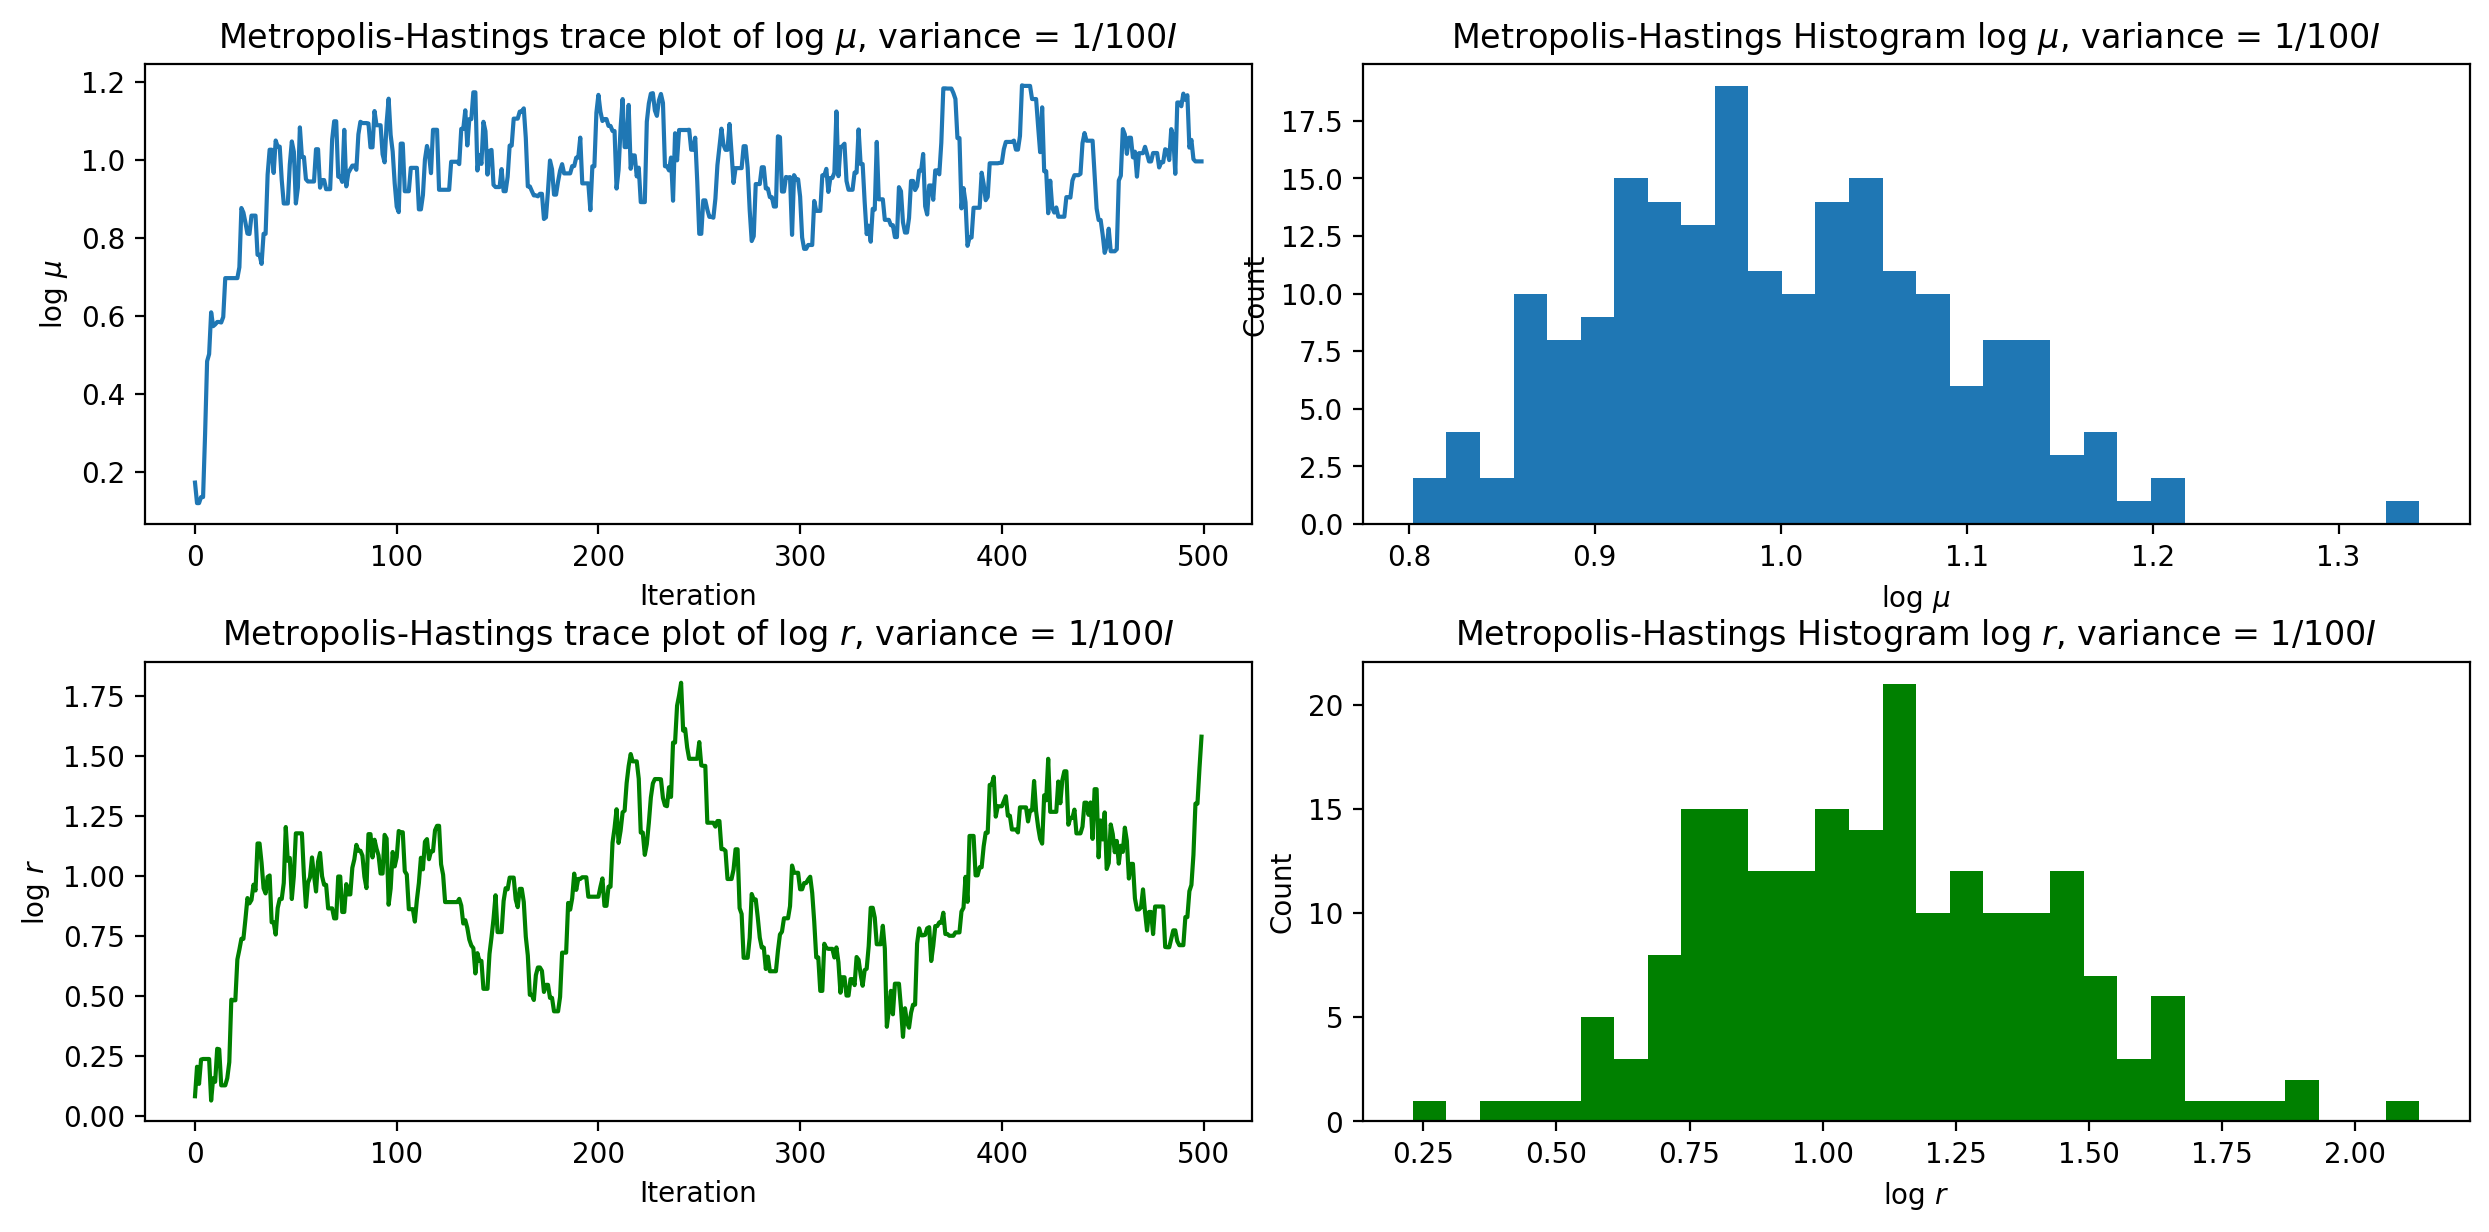

In [1567]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(log_mu_mh)
plt.ylabel(r'log $\mu$')
plt.xlabel('Iteration')
plt.title(r'Metropolis-Hastings trace plot of log $\mu$, variance = 1/100$I$')


plt.subplot(2, 2, 2)
plt.hist(hist_mh[:,0], bins =30)
plt.ylabel('Count')
plt.xlabel(r'log $\mu$')
plt.title(r'Metropolis-Hastings Histogram log $\mu$, variance = 1/100$I$')


plt.subplot(2, 2, 3)
plt.plot(log_r_mh, color ='green')
plt.ylabel(r'log $r$')
plt.xlabel('Iteration')
plt.title(r'Metropolis-Hastings trace plot of log $r$, variance = 1/100$I$')

plt.subplot(2, 2, 4)
plt.hist(hist_mh[:,1], color = 'green', bins =30)
plt.ylabel('Count')
plt.xlabel(r'log $r$')
plt.title(r'Metropolis-Hastings Histogram log $r$, variance = 1/100$I$')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#plt.rcParams['figure.dpi'] = 200
plt.show()

In [1588]:
##hisogram data Hamiltonian Monte Carlo
loops = 200
hist_hmc = np.zeros((loops,2))

for i in range(loops):
    #print(i)
    hist_hmc[i,0] = np.array(hmc(p0,1,0.25))[499,0]
    hist_hmc[i,1] = np.array(hmc(p0,1,0.25))[499,1]

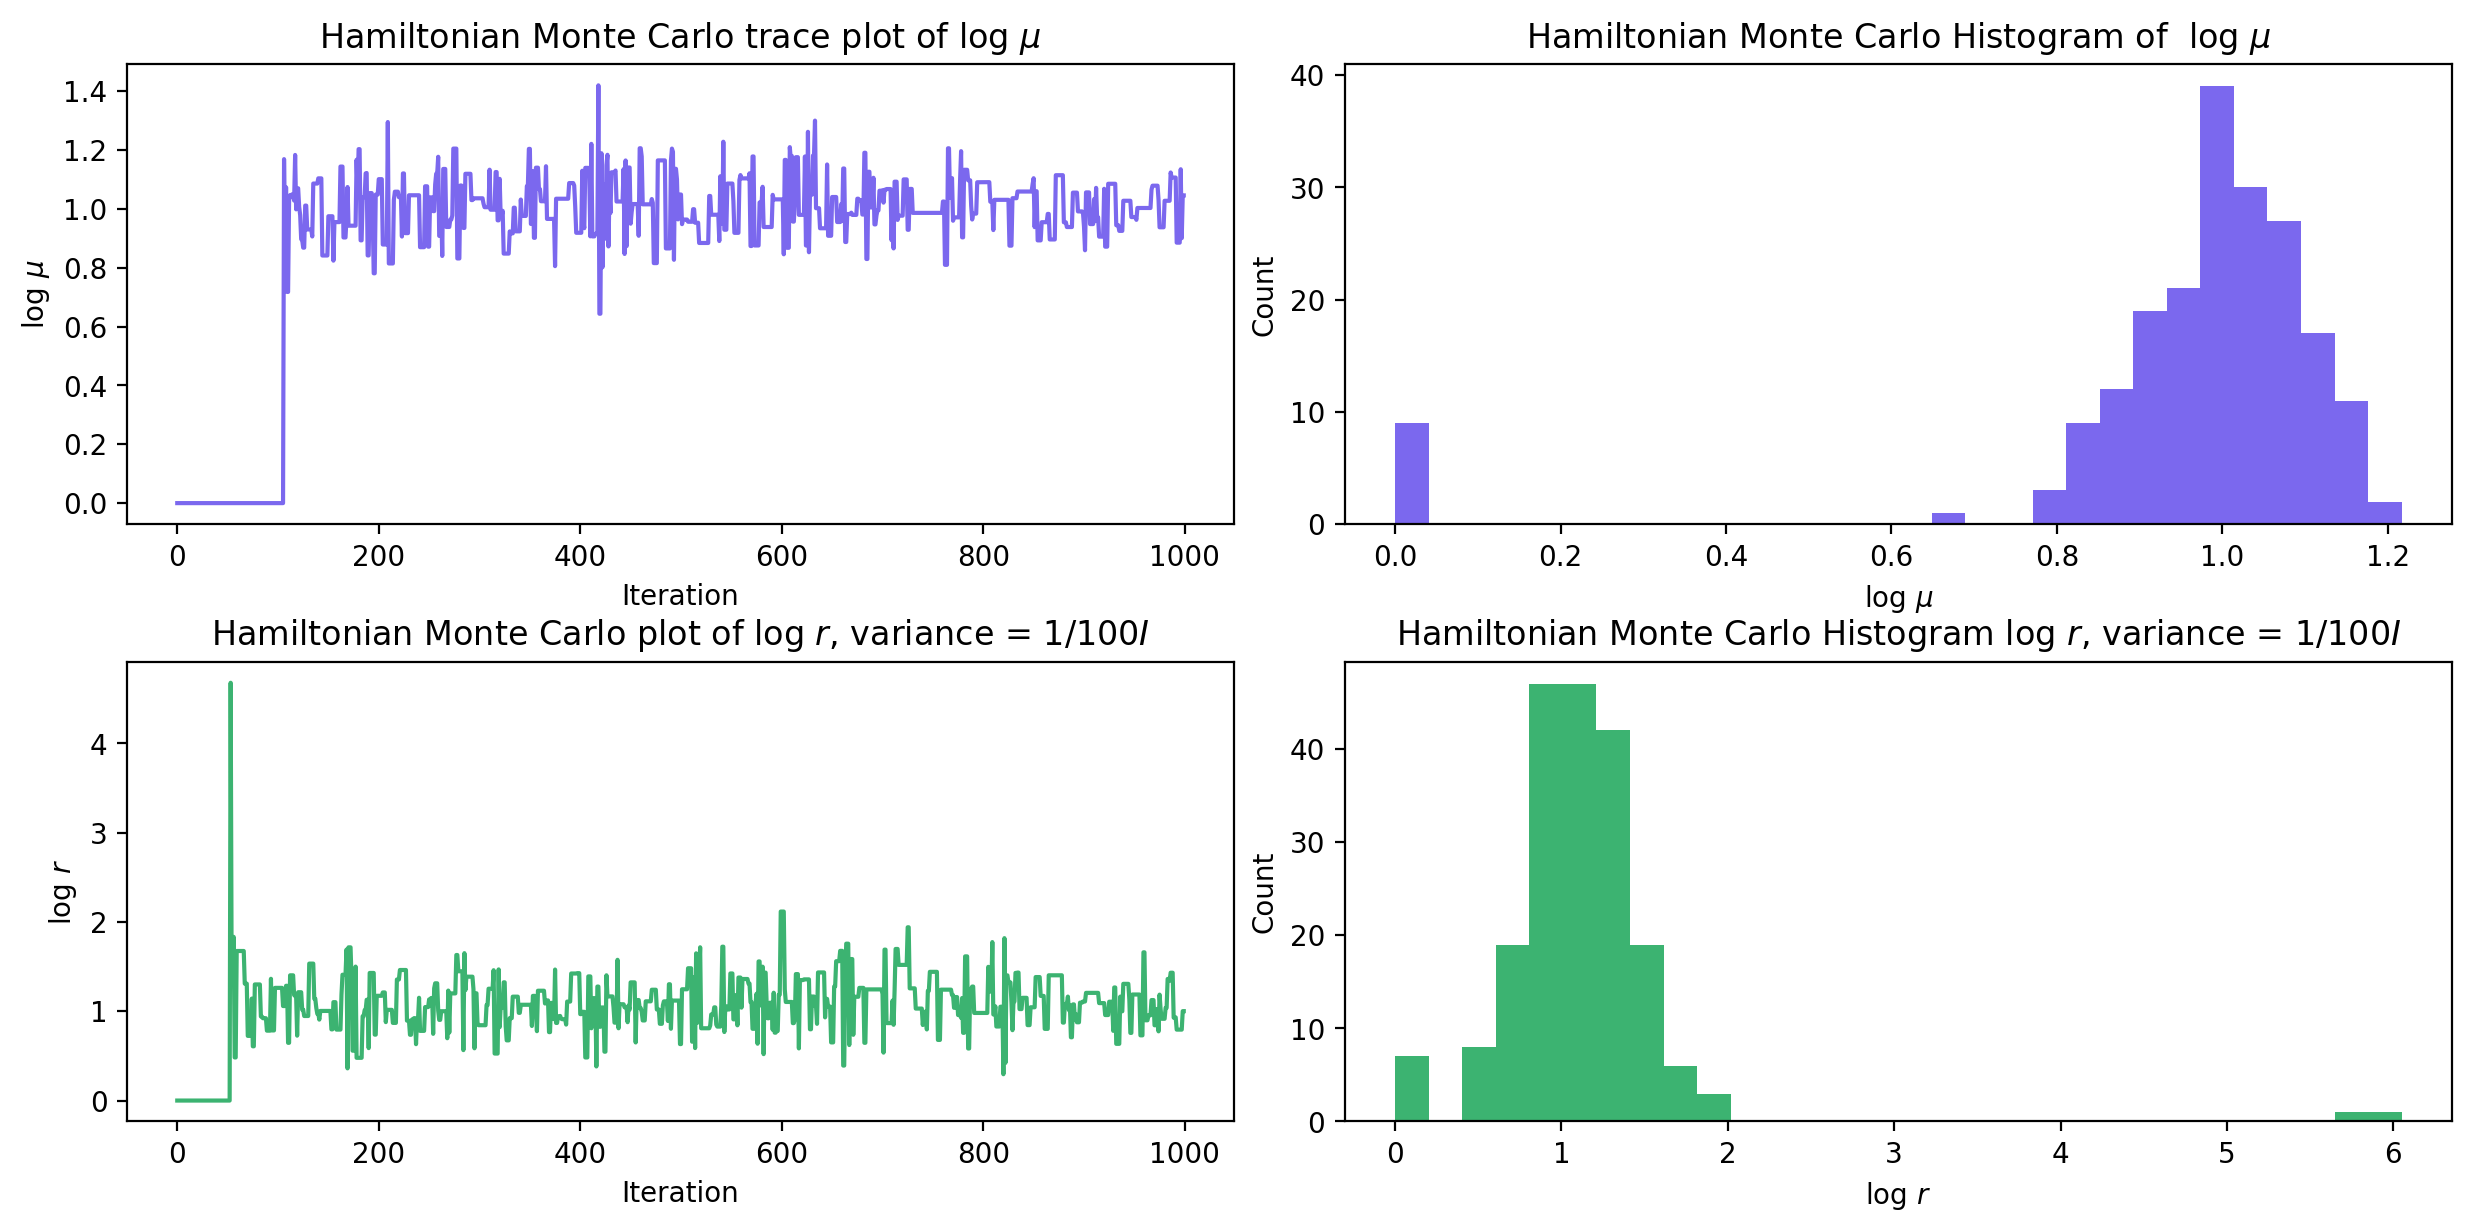

In [1569]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15,7 ))
plt.subplot(2, 2, 1)
plt.plot(log_mu_hmc, color = 'mediumslateblue')
plt.title(r'Hamiltonian Monte Carlo trace plot of log $\mu$')
plt.ylabel(r'log $\mu$')
plt.xlabel('Iteration')



plt.subplot(2, 2, 2)
plt.hist(hist_hmc[:,0], color = 'mediumslateblue', bins =30)
plt.ylabel('Count')
plt.xlabel(r'log $\mu$')
plt.title(r'Hamiltonian Monte Carlo Histogram of  log $\mu$')


plt.subplot(2, 2, 3)
plt.plot(log_r_hmc, color ='mediumseagreen')
plt.ylabel(r'log $r$')
plt.xlabel('Iteration')
plt.title(r'Hamiltonian Monte Carlo plot of log $r$, variance = 1/100$I$')

plt.subplot(2, 2, 4)
plt.hist(hist_hmc[:,1], color = 'mediumseagreen', bins =30)
plt.ylabel('Count')
plt.xlabel(r'log $r$')
plt.title(r'Hamiltonian Monte Carlo Histogram log $r$, variance = 1/100$I$')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#plt.rcParams['figure.dpi'] = 200
plt.show()

## Problem 6: Effective Sample Size

Calculate effective sample size for both chains.

In [1617]:
import tensorflow as tf
import tensorflow_probability as tfp

eff_ss_logrhmc = tfp.mcmc.effective_sample_size(
    log_r_hmc, filter_threshold=0.0, filter_beyond_lag=None,
    filter_beyond_positive_pairs=False, cross_chain_dims=None, validate_args=False,
    name=None)

eff_ss_logmuhmc = tfp.mcmc.effective_sample_size(
    log_mu_hmc, filter_threshold=0.0, filter_beyond_lag=None,
    filter_beyond_positive_pairs=False, cross_chain_dims=None, validate_args=False,
    name=None)

eff_ss_logrmh = tfp.mcmc.effective_sample_size(
    log_r_mh, filter_threshold=0.0, filter_beyond_lag=None,
    filter_beyond_positive_pairs=False, cross_chain_dims=None, validate_args=False,
    name=None)

eff_ss_logmumh = tfp.mcmc.effective_sample_size(
    log_mu_mh, filter_threshold=0.0, filter_beyond_lag=None,
    filter_beyond_positive_pairs=False, cross_chain_dims=None, validate_args=False,
    name=None)

print("The effective sample size for 1000 iterations for \
      Hamiltonian Monte Carlo for log mu is {}".format(eff_ss_logmuhmc.numpy()[0]))

print("The effective sample size for 1000 iterations for \
      Hamiltonian Monte Carlo for log r is {}".format(eff_ss_logrhmc.numpy()[0]))

print("The effective sample size for 1000 iterations for \
      Metropolis Hastings for log mu is {}".format(eff_ss_logmumh.numpy()))

print("The effective sample size for 1000 iterations for \
      Metropolis Hastings for log r is {}".format(eff_ss_logrmh.numpy()))


The effective sample size for 1000 iterations for       Hamiltonian Monte Carlo for log mu is 9.997488948442902
The effective sample size for 1000 iterations for       Hamiltonian Monte Carlo for log r is 51.04806985407336
The effective sample size for 1000 iterations for       Metropolis Hastings for log mu is 27.602668196260865
The effective sample size for 1000 iterations for       Metropolis Hastings for log r is 14.607066945035417


# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw3_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
